---
# Lab Task: Forward Bank Bills and Enhanced Yield Curve Bootstrap #
---

In this lab, you will extend the existing class structure to handle **forward-starting bank bills** and build a yield curve that can bootstrap using these forward instruments.

## Background: Forward Bank Bills

A **forward bank bill** is a contract made today to purchase a bank bill at a future date. Unlike a regular bank bill that starts today, a forward bank bill:
- Has a **start date** in the future
- Has a **maturity date** beyond the start date  
- Allows market participants to lock in rates for future periods

### Example

A "3-month bank bill starting in 6 months" (denoted as a 6x9 forward):
- You agree today to a price
- In 6 months (start date), you pay that price
- In 9 months (maturity), you receive the face value

### Cash Flows

A forward bank bill has two key dates:
1. **Start date**: The date when you pay the price (negative cash flow)
2. **Maturity date**: The date when you receive the face value (positive cash flow)

### Why Forward Bills Matter for Yield Curves

Forward bank bills provide information about **implied forward rates** between two future points in time. By including them in the reference portfolio, we can:
- Build a more complete yield curve
- Extract market expectations about future interest rates
- Improve interpolation between sparse maturity points

## Lab Tasks Overview

You will:
1. Create a `Forward_bank_bill` class that inherits from `Bank_bill`
2. Create a `YieldCurve_with_forward_bills` class that inherits from `YieldCurve` 
3. Update the bootstrap method to handle forward-starting instruments
4. Instantiate a portfolio with both spot and forward instruments
5. Build a yield curve and test it with a set of cash flows

---

### Step 0: Import Required Classes

Import the necessary classes and functions from the existing modules.

In [1]:
from instrument_classes import Bank_bill, Bond, Portfolio, CashFlows
from curve_classes_and_functions import YieldCurve
import numpy as np
import pandas as pd

---

### Step 1: Create the Forward_bank_bill Class

Create a new class `Forward_bank_bill` that inherits from `Bank_bill` with the following specifications:

**Requirements:**
- Add a `start_date` parameter to the `__init__` method (in addition to the existing Bank_bill parameters)
- The `maturity` parameter should represent the total time from now to final maturity
- The `start_date` represents the time from now to when the bill starts
- Override the `set_cash_flows()` method to create cash flows at:
  - `start_date`: negative cash flow equal to `-price`
  - `maturity`: positive cash flow equal to `face_value`
- Add getter methods for `start_date` and the forward period (`maturity - start_date`)

**Hints:**
- Use `super().__init__()` to call the parent class constructor
- For a forward bill, the pricing relationship involves both the start and maturity dates
- The forward rate can be calculated from the price and the forward period

**Example usage (after implementation):**
```python
# A 3-month bill starting in 6 months (6x9 forward)
fwd_bill = Forward_bank_bill(face_value=100, start_date=0.5, maturity=0.75)
fwd_bill.set_ytm(0.04)  # 4% forward rate
fwd_bill.set_cash_flows()
```

In [2]:
# Create your Forward_bank_bill class here:

class Forward_bank_bill(Bank_bill):
    def __init__(self, start_date = 0, face_value = 100, maturity = 0, ytm=0.00, price=100):
        super().__init__(face_value, maturity, ytm, price)
        self.start_date = start_date
        self.forward_period = self.maturity - self.start_date

    def set_cash_flows(self):
        self.add_cash_flow(self.start_date, -self.price)
        self.add_cash_flow(self.maturity, self.face_value)

    def get_start_date(self): 
        return self.start_date
    
    def get_forward_period(self):
        return self.forward_period
    
    def set_ytm(self, ytm): 
        self.ytm = ytm
        self.price = self.face_value/(1+ytm*self.forward_period)

    def set_price(self, price):
        self.price = price 
        self.ytm = (self.face_value/self.price-1)/(self.forward_period)


---

### Step 2: Create the YieldCurve_with_forward_bills Class

Create a new class `YieldCurve_with_forward_bills` that inherits from `YieldCurve` and enhances the bootstrap method.

**Requirements:**

1. Override the `bootstrap()` method to handle forward bank bills
2. The method should:
   - Start by calling `self.add_zero_rate(0, 0)` to set the discount factor at time 0
   - Process regular (spot) bank bills first, in order of maturity
     - For each spot bill: extract the discount factor at its maturity
   - Process forward bank bills next, in order of their maturity (not start date)
     - For each forward bill: use the known discount factor at the start date and the bill's pricing to solve for the discount factor at the maturity date
   - Process bonds last, in order of maturity
     - For each bond: use all previously determined discount factors to value intermediate coupons, then solve for the discount factor at the bond's maturity

**Key Insight for Forward Bills:**

For a forward bill with:
- Price = P
- Face value = F  
- Start date = $t_1$
- Maturity = $t_2$

The present value equation is:
$$NPV = -P \cdot DF(t_1) + F \cdot DF(t_2) = 0$$

Therefore:
$$DF(t_2) = \frac{P}{F} \cdot DF(t_1)$$

**Hints:**
- You'll need to distinguish between regular bank bills and forward bank bills
- Use `isinstance(bill, Forward_bank_bill)` to check if an instrument is a forward bill
- You can access the portfolio's bank bills with `self.portfolio.get_bank_bills()`
- For forward bills, you'll need to call `get_discount_factor(start_date)` from the curve
- Regular bills are just forward bills with start_date = 0

In [3]:
# Create your YieldCurve_with_forward_bills class here:

class YieldCurve_with_forward_bills(YieldCurve):
    def __init__(self):
        super().__init__()

    def bootstrap(self):
        all_bank_bills = self.portfolio.get_bank_bills()
        bonds = self.portfolio.get_bonds()
        bank_bills = []
        forward_bank_bills = []
        for bill in all_bank_bills: 
            if isinstance(bill, Forward_bank_bill):
                forward_bank_bills.append(bill)
            else: 
                bank_bills.append(bill)

        self.add_zero_rate(0,0)

        for bank_bill in bank_bills:
            self.add_discount_factor(bank_bill.get_maturity(),bank_bill.get_price()/bank_bill.get_face_value())
            
        for forward_bank_bill in forward_bank_bills:
            df_start = self.get_discount_factor(forward_bank_bill.get_start_date())
            df_maturity = (forward_bank_bill.get_price()/forward_bank_bill.get_face_value()*df_start)
            self.add_discount_factor(forward_bank_bill.get_maturity(),df_maturity)

        for bond in bonds:
            # calculate the PV of the bond cashflows excluding the maturity cashflow
            pv = 0
            bond_dates = bond.get_maturities()
            bond_amounts = bond.get_amounts()
            for i in range(1, len(bond_amounts)-1):
                pv += bond_amounts[i]*self.get_discount_factor(bond_dates[i])
            # print("PV of all the cashflows except maturity is: ", pv)
            # print("The bond price is: ", bond.get_price())
            # print("The last cashflow is: ", bond_amounts[-1])
            self.add_discount_factor(bond.get_maturity(),(bond.get_price()-pv)/bond.get_amounts()[-1])

        

---

### Step 3: Create the Reference Portfolio

Now create a reference portfolio containing the following instruments:

**Required Instruments:**

1. **One regular 3-month bank bill** (0.25 years)
   - Face value: 100
   - YTM: 3.0%

2. **Three forward bank bills (all 3-month bills):**
   - **3x6 forward**: starts in 3 months (0.25 years), matures in 6 months (0.5 years)
     - Face value: 100
     - YTM: 3.2%
   - **6x9 forward**: starts in 6 months (0.5 years), matures in 9 months (0.75 years)
     - Face value: 100
     - YTM: 3.4%
   - **9x12 forward**: starts in 9 months (0.75 years), matures in 12 months (1.0 year)
     - Face value: 100
     - YTM: 3.6%

3. **One 1-year quarterly coupon bond** (1.0 year maturity)
   - Face value: 100
   - Coupon rate: 4.0% per annum
   - Frequency: 4 (quarterly)
   - YTM: 3.8%

4. **One 2-year annual coupon bond** (2.0 years maturity)
   - Face value: 100
   - Coupon rate: 4.5% per annum
   - Frequency: 1 (annual)
   - YTM: 4.2%

**Important Steps:**
- For each instrument, set the YTM using `.set_ytm()`
- For each instrument, call `.set_cash_flows()` to generate the cash flow schedule
- Create a `Portfolio` object and add all instruments in the correct order
- Remember: add bank bills (spot then forward) before bonds

In [4]:
# Create the regular 3-month bank bill
regular_bb = Bank_bill(face_value=100, maturity=0.25)
regular_bb.set_ytm(0.03)
regular_bb.set_cash_flows()

In [5]:
# Create the three forward bank bills (3x6, 6x9, 9x12)
forward_bb_3x6 = Forward_bank_bill(start_date=0.5, face_value=100, maturity=0.75)
forward_bb_3x6.set_ytm(0.032)
forward_bb_3x6.set_cash_flows()

forward_bb_6x9 =Forward_bank_bill(start_date=0.25, face_value=100, maturity=0.5)
forward_bb_6x9.set_ytm(0.034)
forward_bb_6x9.set_cash_flows()

forward_bb_9x12 = Forward_bank_bill(start_date=0.75, face_value=100, maturity=1.0)
forward_bb_9x12.set_ytm(0.036)
forward_bb_9x12.set_cash_flows()


In [6]:
# Create the 1-year quarterly bond
bond_1y = Bond(face_value=100, maturity=1, coupon=0.04, frequency=4)
bond_1y.set_ytm(0.038)
bond_1y.set_cash_flows()

In [7]:
# Create the 2-year annual bond
bond_2y = Bond(face_value=100, maturity=2, coupon=0.045, frequency=1)
bond_2y.set_ytm(0.042)
bond_2y.set_cash_flows()
# Your code here

In [8]:
# Create a Portfolio and add all instruments
my_portfolio = Portfolio()
my_portfolio.add_bank_bill(regular_bb)

my_portfolio.add_bank_bill(forward_bb_3x6)
my_portfolio.add_bank_bill(forward_bb_6x9)
my_portfolio.add_bank_bill(forward_bb_9x12)

my_portfolio.add_bond(bond_1y)
my_portfolio.add_bond(bond_2y)
# Your code here

---

### Step 4: Build the Yield Curve

Now instantiate your `YieldCurve_with_forward_bills` class, set the constituent portfolio, and run the bootstrap method.

After bootstrapping, display the resulting discount factors and zero rates at the key maturities.

In [15]:
# Create the yield curve instance
mycurve = YieldCurve_with_forward_bills()
mycurve.set_constituent_portfolio(my_portfolio)
mycurve.bootstrap()
print(f"Curve contains {len(mycurve.maturities)} maturity points")

Curve contains 7 maturity points


In [58]:
# Display the curve results in a nice table
# Hint: Create a DataFrame with columns for Maturity, Discount Factor, and Zero Rate

curve_data = { 'Maturity (years)': mycurve.maturities,
    'Discount Factor': mycurve.discount_factors,
    'Zero Rate (%)': [r * 100 for r in mycurve.zero_rates]}
curve_df=pd.DataFrame(curve_data).sort_index() 
print(curve_df.to_string(index=False))


 Maturity (years)  Discount Factor  Zero Rate (%)
             0.00         1.000000       0.000000
             0.25         0.992556       2.988806
             0.50         0.977348       3.054960
             0.75         0.984190       3.187194
             1.00         0.968631       3.187219
             1.00         0.962785       3.792557
             2.00         0.920626       4.135093


---

### Step 5: Test the Yield Curve

Create a `CashFlows` object with the following cash flows and calculate its present value using the yield curve:

**Cash Flow Schedule:**
- 0.5 years: $25
- 1.0 year: $30
- 1.5 years: $35
- 2.0 years: $110

Use the `npv()` method from your yield curve to calculate the present value.

**Expected behavior:**
- The curve should interpolate discount factors at 1.5 years (which is not a reference portfolio maturity)
- You should see a reasonable present value (approximately in the range of $180-$195)

In [65]:
# Create a CashFlows object and add the cash flows
cash_flows = CashFlows()
cash_flows.add_cash_flow(0.5,25)
cash_flows.add_cash_flow(1, 30)
cash_flows.add_cash_flow(1.5, 35)
cash_flows.add_cash_flow(2, 110)

In [64]:
# Calculate and display the NPV
npv = mycurve.npv(cash_flows)
print("the NPV of the portfolio is:", round(npv,2))


the NPV of the portfolio is: 187.71


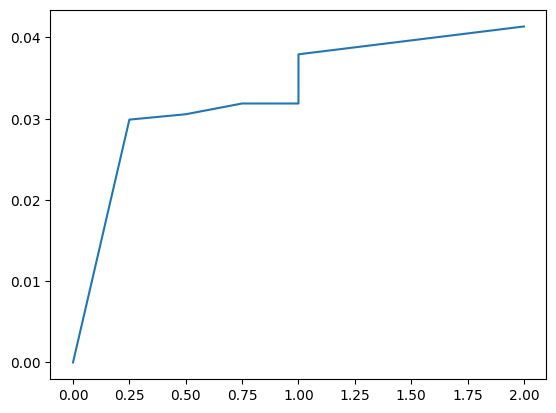

In [66]:
#plotting the curve 
import matplotlib.pyplot as plt
xvalues = mycurve.maturities
yvalues = mycurve.zero_rates

plt.plot(xvalues, yvalues)


---

### Step 6: Analysis Questions

Answer the following questions based on your results:

1. **Forward Rate Interpretation**: Compare the YTMs of the regular 3-month bill (3.0%) with the forward bills (3.2%, 3.4%, 3.6%). What does this tell you about the market's expectation of future interest rates?

2. **Discount Factor Pattern**: Look at your discount factors. Do they decrease as maturity increases? Why is this expected?

3. **Zero Rate Curve Shape**: Plot or examine the zero rates from 0.25 to 2.0 years. Is the curve upward sloping, downward sloping, or flat? What does this imply about the term structure?

4. **Interpolation**: The cash flow at 1.5 years requires interpolation. What interpolation method does the ZeroCurve class use? (Hint: check the `get_discount_factor()` method)

5. **Bootstrap Order**: Why is it important to process the instruments in order of maturity when bootstrapping? What would go wrong if you tried to process the 2-year bond before all the shorter-maturity instruments?

**Your answers here:**

1. Forward Rate Interpretation:
The YTM of the forward bills is lower than that of the forward bills, the market is pricing tells us that therefore they are expecting future interest rates to rise

2. Discount Factor Pattern:
As maturity increases the discount factor will decrease, this account for the time value of money and will result in the FV being discounted to a larger effect to account for the time value of money 

3. Zero Rate Curve Shape:
the zero rate curve is upward sloping, suggesting that a higher interest rate is required for money to be lent by investors for a longer period of time

4. Interpolation Method:
it uses an expontnetial interpolation method using continuously compounded rates, it calculates the continuously compounded rate between two known points and uses this rate to exponentially interpolate values between the points


5. Bootstrap Order:
Because bootstrapping using the rates calculated form a shorter time period to equate the rates over the same period, hence you must start with the shortest period


---

### Optional Extension: Visualize the Yield Curve

Create a plot showing:
1. The zero rate curve
2. The discount factor curve

Use matplotlib to create these visualizations.

In [62]:
# Optional: Visualization code
import matplotlib.pyplot as plt

# Your code here

---

## Summary

In this lab, you have:
- ✅ Created a `Forward_bank_bill` class to represent forward-starting instruments
- ✅ Extended the `YieldCurve` class to handle forward bills in the bootstrap process
- ✅ Built a complete yield curve from a mixed portfolio of spot and forward instruments
- ✅ Tested the curve by valuing a set of cash flows
- ✅ Analyzed the term structure of interest rates

**Key Takeaways:**
- Forward instruments provide information about market expectations of future rates
- The bootstrap method must be carefully sequenced to build up the curve progressively
- Interpolation allows us to value cash flows at dates not in the reference portfolio
- The yield curve is a fundamental tool for pricing fixed-income securities

---